# Advanced AI RAG Framework with Auto Reasoning and Prompting

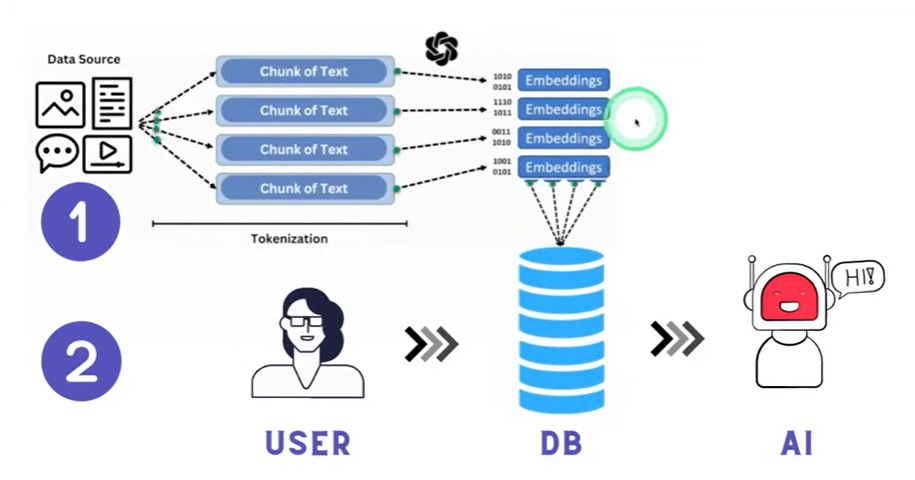

# Issue: 1. RETRIEVAL

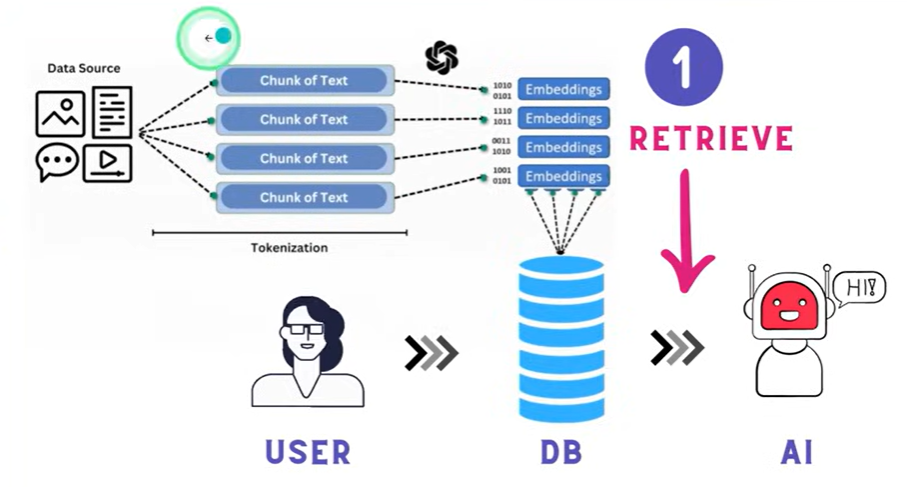

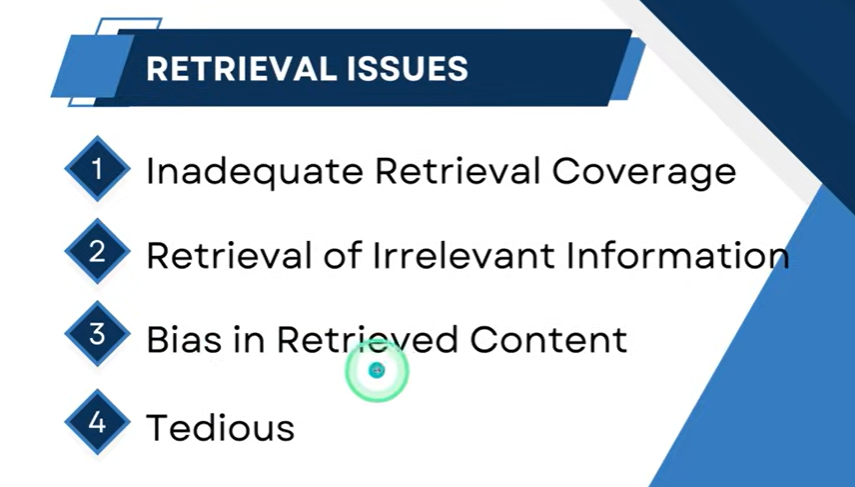

# Issue: 2. GENERATE

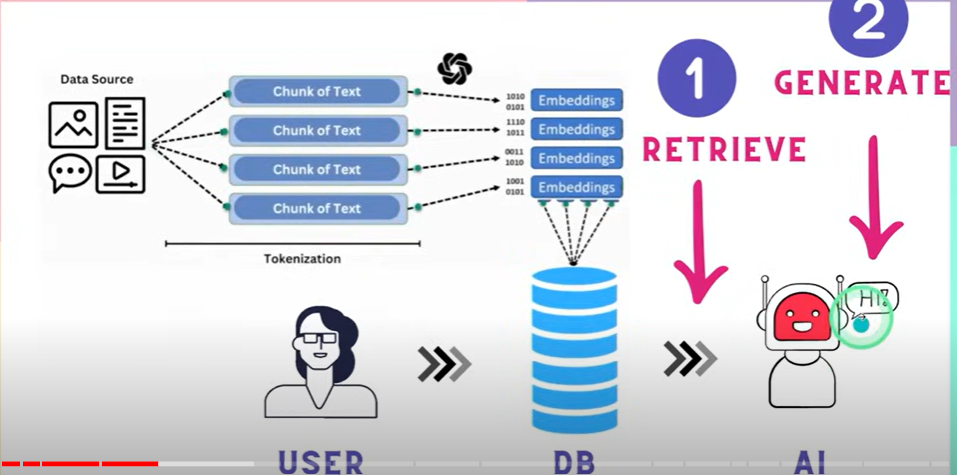

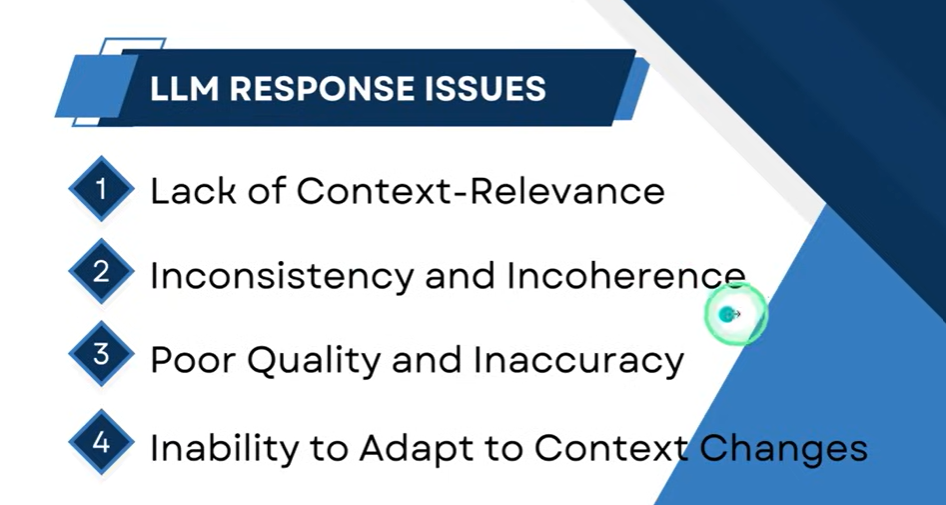

# DSPy

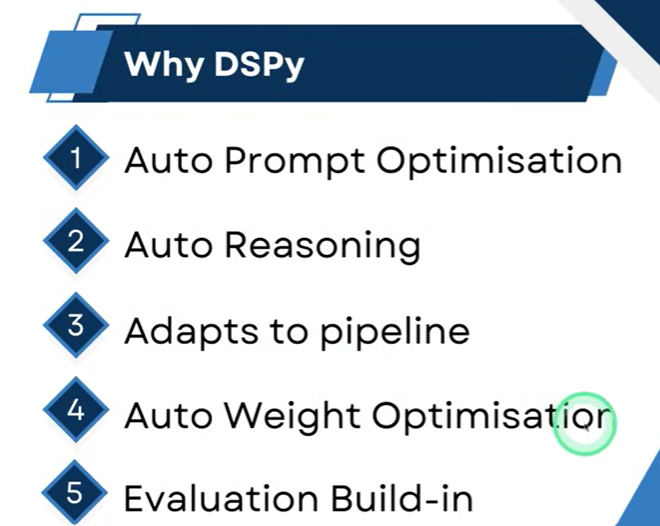

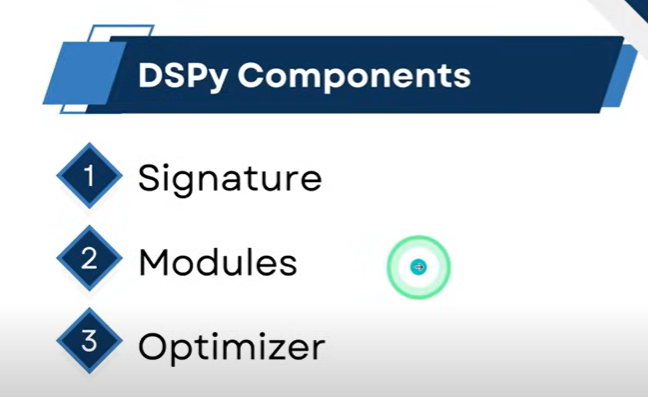

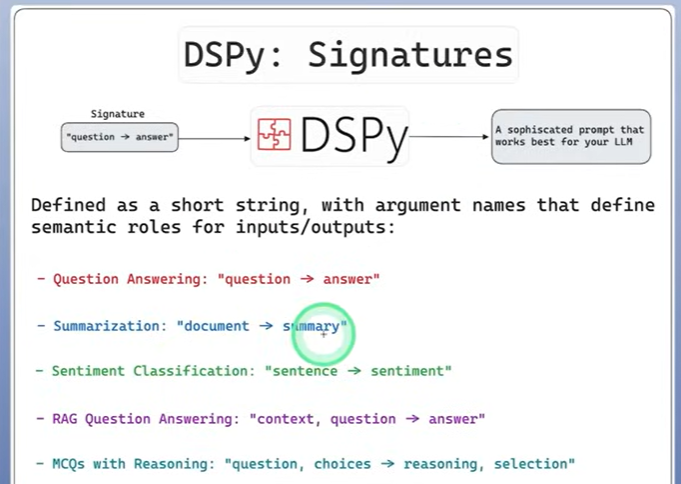

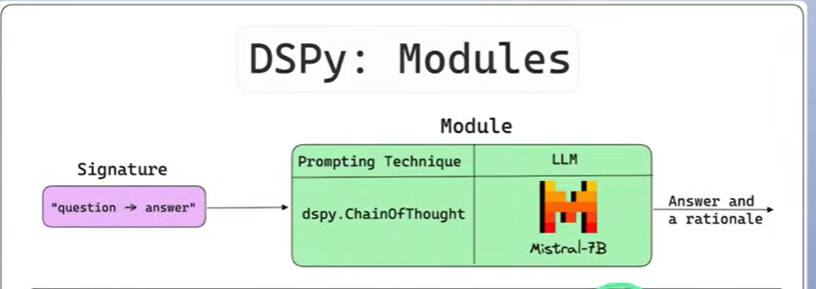

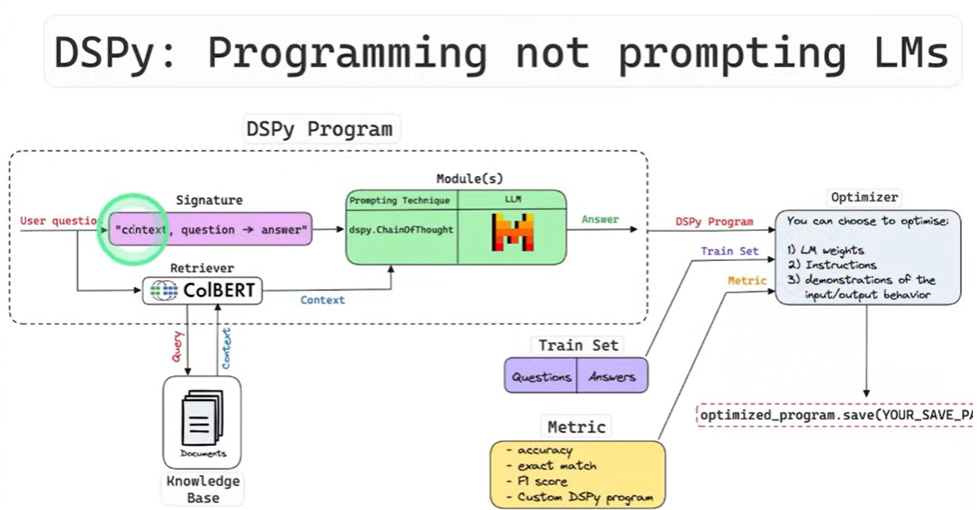

In [2]:
#https://mer.vin/2024/05/dspy-beginners-crash-course/

In [1]:
import sys
import os
import dspy
from dspy.datasets import HotPotQA
from dspy.teleprompt import BootstrapFewShot
from dspy.evaluate.evaluate import Evaluate
from dsp.utils import deduplicate
from rich import print

In [3]:
# Set API key for Azure
os.environ["OPENAI_API_KEY"] = ""

In [4]:
# 1. Configuration & Data Loading
turbo = dspy.OpenAI(model='gpt-3.5-turbo')
colbertv2_wiki17_abstracts = dspy.ColBERTv2(url='http://20.102.90.50:2017/wiki17_abstracts')
dspy.settings.configure(lm=turbo, rm=colbertv2_wiki17_abstracts)
dataset = HotPotQA(train_seed=1, train_size=20, eval_seed=2023, dev_size=50, test_size=0)

Generating train split:   0%|          | 0/90447 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7405 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7405 [00:00<?, ? examples/s]

In [5]:
trainset = [x.with_inputs('question') for x in dataset.train]
devset = [x.with_inputs('question') for x in dataset.dev]

print(len(trainset), len(devset))
print(f"Trainset Data {trainset[:5]}")
print(f"Devset Data {devset[:5]}")

20 50

Trainset Data [Example({'question': 'At My Window was released by which American singer-songwriter?', 'answer': 
'John Townes Van Zandt'}) (input_keys={'question'}), Example({'question': 'which  American actor was Candace Kita  
guest starred with ', 'answer': 'Bill Murray'}) (input_keys={'question'}), Example({'question': 'Which of these 
publications was most recently published, Who Put the Bomp or Self?', 'answer': 'Self'}) (input_keys={'question'}),
Example({'question': 'The Victorians - Their Story In Pictures is a documentary series written by an author born in
what year?', 'answer': '1950'}) (input_keys={'question'}), Example({'question': 'Which magazine has published 
articles by Scott Shaw, Tae Kwon Do Times or Southwest Art?', 'answer': 'Tae Kwon Do Times'}) 
(input_keys={'question'})]

Devset Data [Example({'question': 'Are both Cangzhou and Qionghai in the Hebei province of China?', 'answer': 'no',
'gold_titles': {'Qionghai', 'Cangzhou'}}) (input_keys={'question'}), Example({'question': 'Who conducts the draft 
in which Marc-Andre Fleury was drafted to the Vegas Golden Knights for the 2017-18 season?', 'answer': 'National 
Hockey League', 'gold_titles': {'2017 NHL Expansion Draft', '2017–18 Pittsburgh Penguins season'}}) 
(input_keys={'question'}), Example({'question': 'The Wings entered a new era, following the retirement of which 
Canadian retired professional ice hockey player and current general manager of the Tampa Bay Lightning of the 
National Hockey League (NHL)?', 'answer': 'Steve Yzerman', 'gold_titles': {'Steve Yzerman', '2006–07 Detroit Red 
Wings season'}}) (input_keys={'question'}), Example({'question': 'What river is near the Crichton Collegiate 
Church?', 'answer': 'the River Tyne', 'gold_titles': {'Crichton Collegiate Church', 'Crichton Castle'}}) 
(input_keys={'question'}), Example({'question': 'In the 10th Century A.D. Ealhswith had a son called Æthelweard by 
which English king?', 'answer': 'King Alfred the Great', 'gold_titles': {'Æthelweard (son of Alfred)', 
'Ealhswith'}}) (input_keys={'question'})]

In [8]:
print("\n### Example Question with Answer ###\n")
example = devset[18]
print(f"Question: {example.question}")
print(f"Answer: {example.answer}")
print(f"Relevant Wikipedia Titles: {example.gold_titles}")

### Example Question with Answer ###

Question: What is the nationality of the chef and restaurateur featured in Restaurant: Impossible?

Answer: English

Relevant Wikipedia Titles: {'Restaurant: Impossible', 'Robert Irvine'}

In [ ]:
# 2. Basic Chatbot
class BasicQA(dspy.Signature):  # A. Signature
    """Answer questions with short factoid answers."""
    question = dspy.InputField()
    answer = dspy.OutputField(desc="often between 1 and 5 words")

print("\n### Generate Response ###\n")
generate_answer = dspy.Predict(BasicQA)
pred = generate_answer(question=example.question)
print(f"Question: {example.question}\nPredicted Answer: {pred.answer}")

In [ ]:
# 3. Chatbot with Chain of Thought
print("\n### Generate Response with Chain of Thought ###\n")
generate_answer_with_chain_of_thought = dspy.ChainOfThought(BasicQA)
pred = generate_answer_with_chain_of_thought(question=example.question)
print(f"Question: {example.question}\nThought: {pred.rationale.split('.', 1)[1].strip()}\nPredicted Answer: {pred.answer}")

In [ ]:
# 4. Chatbot with Chain of Thought and Context = RAG --> (Retrieve, Generate Response)
print("\n### RAG: Generate Response with Chain of Thought and Context ###\n")

In [ ]:
# 4a. Signature
class GenerateAnswer(dspy.Signature): 
    """Answer questions with short factoid answers."""
    context = dspy.InputField(desc="may contain relevant facts")
    question = dspy.InputField()
    answer = dspy.OutputField(desc="often between 1 and 5 words")

In [ ]:
# 4b. Module / Pipeline
class RAG(dspy.Module): 
    def __init__(self, num_passages=3):
        super().__init__()
        self.retrieve = dspy.Retrieve(k=num_passages)
        self.generate_answer = dspy.ChainOfThought(GenerateAnswer)
    
    def forward(self, question):
        context = self.retrieve(question).passages
        prediction = self.generate_answer(context=context, question=question)
        return dspy.Prediction(context=context, answer=prediction.answer)


In [ ]:
# 4c. Optimizer / Optimising Pipeline
def validate_context_and_answer(example, pred, trace=None): 
    answer_EM = dspy.evaluate.answer_exact_match(example, pred)
    answer_PM = dspy.evaluate.answer_passage_match(example, pred)
    return answer_EM and answer_PM

teleprompter = BootstrapFewShot(metric=validate_context_and_answer) 
compiled_rag = teleprompter.compile(RAG(), trainset=trainset)

In [ ]:
# 4d. Executing Pipeline
my_question = "What castle did David Gregory inherit?" 
pred = compiled_rag(my_question)

print(f"Question: {my_question}")
print(f"Predicted Answer: {pred.answer}")
print(f"Retrieved Contexts (truncated): {[c[:200] + '...' for c in pred.context]}")


In [ ]:
# 5. Evaluating the Answers
print("\n### Evaluating the Answers ###\n")

In [ ]:
# 5a. Basic RAG
def gold_passages_retrieved(example, pred, trace=None):
    gold_titles = set(map(dspy.evaluate.normalize_text, example['gold_titles']))
    found_titles = set(map(dspy.evaluate.normalize_text, [c.split(' | ')[0] for c in pred.context]))
    return gold_titles.issubset(found_titles)

evaluate_on_hotpotqa = Evaluate(devset=devset, num_threads=1, display_progress=True, display_table=5)
compiled_rag_retrieval_score = evaluate_on_hotpotqa(compiled_rag, metric=gold_passages_retrieved)


In [ ]:
# 5b. Uncompiled Baleen RAG (without Optimizer)
class GenerateSearchQuery(dspy.Signature):
    """Write a simple search query that will help answer a complex question."""
    context = dspy.InputField(desc="may contain relevant facts")
    question = dspy.InputField()
    query = dspy.OutputField()

class SimplifiedBaleen(dspy.Module):
    def __init__(self, passages_per_hop=3, max_hops=2):
        super().__init__()
        self.generate_query = [dspy.ChainOfThought(GenerateSearchQuery) for _ in range(max_hops)]
        self.retrieve = dspy.Retrieve(k=passages_per_hop)
        self.generate_answer = dspy.ChainOfThought(GenerateAnswer)
        self.max_hops = max_hops
    
    def forward(self, question):
        context = []
        for hop in range(self.max_hops):
            query = self.generate_query[hop](context=context, question=question).query
            passages = self.retrieve(query).passages
            context = deduplicate(context + passages)
        pred = self.generate_answer(context=context, question=question)
        return dspy.Prediction(context=context, answer=pred.answer)

uncompiled_baleen = SimplifiedBaleen()  # uncompiled (i.e., zero-shot) program
pred = uncompiled_baleen(my_question)
print(f"Question: {my_question}")
print(f"Predicted Answer: {pred.answer}")
print(f"Retrieved Contexts (truncated): {[c[:200] + '...' for c in pred.context]}")


In [ ]:
# 5c. Compiled Baleen RAG (with Optimizer)
def validate_context_and_answer_and_hops(example, pred, trace=None):
    if not dspy.evaluate.answer_exact_match(example, pred): return False
    if not dspy.evaluate.answer_passage_match(example, pred): return False
    hops = [example.question] + [outputs.query for *_, outputs in trace if 'query' in outputs]
    if max([len(h) for h in hops]) > 100: return False
    if any(dspy.evaluate.answer_exact_match_str(hops[idx], hops[:idx], frac=0.8) for idx in range(2, len(hops))): return False
    return True

teleprompter = BootstrapFewShot(metric=validate_context_and_answer_and_hops)
compiled_baleen = teleprompter.compile(SimplifiedBaleen(), teacher=SimplifiedBaleen(passages_per_hop=2), trainset=trainset)
uncompiled_baleen_retrieval_score = evaluate_on_hotpotqa(uncompiled_baleen, metric=gold_passages_retrieved)
compiled_baleen_retrieval_score = evaluate_on_hotpotqa(compiled_baleen, metric=gold_passages_retrieved)

print(f"## Retrieval Score for RAG: {compiled_rag_retrieval_score}")
print(f"## Retrieval Score for uncompiled Baleen: {uncompiled_baleen_retrieval_score}")
print(f"## Retrieval Score for compiled Baleen: {compiled_baleen_retrieval_score}")

compiled_baleen("How many storeys are in the castle that David Gregory inherited?")
